In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import warnings

In [2]:
train = pd.read_csv('train_log.csv')
test = pd.read_csv('test_log.csv')

In [3]:
new_train = train
new_test = test

In [4]:
new_train.drop(columns=['enroll_id', 'object'], inplace=True)
new_test.drop(columns=['enroll_id', 'object'], inplace=True)

In [5]:
# Substitute various actions with category-type actions
video_action = ['seek_video','play_video','pause_video','stop_video','load_video']
problem_action = ['problem_get','problem_check','problem_save','reset_problem','problem_check_correct', 'problem_check_incorrect']
forum_action = ['create_thread','create_comment','delete_thread','delete_comment']
click_action = ['click_info','click_courseware','click_about','click_forum','click_progress']
close_action = ['close_courseware']

video = ['video']*len(video_action)
problem = ['problem']*len(problem_action)
forum = ['forum']*len(forum_action)
click = ['click']*len(click_action)
close = ['close']*len(close_action)

video_dict = dict(zip(video_action, video))
problem_dict = dict(zip(problem_action, problem))
forum_dict = dict(zip(forum_action, forum))
click_dict = dict(zip(click_action, click))
close_dict = dict(zip(close_action, close))

new_train['action'].replace(video_dict, inplace=True)
new_train['action'].replace(problem_dict, inplace=True)
new_train['action'].replace(forum_dict, inplace=True)
new_train['action'].replace(click_dict, inplace=True)
new_train['action'].replace(close_dict, inplace=True)

new_test['action'].replace(video_dict, inplace=True)
new_test['action'].replace(problem_dict, inplace=True)
new_test['action'].replace(forum_dict, inplace=True)
new_test['action'].replace(click_dict, inplace=True)
new_test['action'].replace(close_dict, inplace=True)


### Retrieve time spent on courses from join with course_info dataframe

In [6]:
courseinfo = pd.read_csv('course_info.csv', index_col='id')

In [7]:
new_train = new_train.merge(courseinfo, on='course_id')
new_test = new_test.merge(courseinfo, on='course_id')

In [8]:
data = pd.concat([new_train, new_test], ignore_index=True)

In [9]:
data.drop(columns=['session_id', 'action', 'start', 'end', 'course_type', 'category'], inplace=True)

In [10]:
data.rename(columns={'time': 'date'}, inplace=True)
data['date'] = pd.to_datetime(data['date'])

In [11]:
data['date'] = data['date'].dt.date

In [12]:
data['count'] = len(data)*[1]

In [13]:
data = data.groupby(by=['username', 'course_id', 'date']).count().reset_index()

In [14]:
data

,username,course_id,date,count
0,5,TsinghuaX/60510102X/_,2015-10-12,11
1,5,TsinghuaX/70240183x/2015_T2,2015-09-30,43
2,5,TsinghuaX/80511503X/2015_T2,2015-11-10,8
3,5,TsinghuaX/80511503X/2015_T2,2015-11-13,50
4,5,TsinghuaX/80511503X/2015_T2,2015-11-16,1
...,...,...,...,...
673155,7011178,course-v1:TsinghuaX+AP000008X+2017T1,2017-05-05,46
673156,7019483,course-v1:TsinghuaX+20320074X+2017_T1,2017-05-11,40
673157,7023562,course-v1:TsinghuaX+AP000008X+2017T1,2017-05-12,267
673158,7036067,course-v1:TsinghuaX+AP000008X+2017T1,2017-05-15,20


In [15]:
temp = data.pivot(index=['username', 'course_id'], columns='date').fillna(0).reset_index()

In [16]:
temp.columns = temp.columns.droplevel()

In [17]:
cols = list(temp.columns)
cols[0] = 'username'
cols[1] = 'course_id'
temp.columns = cols

In [18]:
temp.drop(columns=['username', 'course_id'], inplace=True)

## Build Prophet model for platform traffic prediction

In [19]:
df_prophet_pivot = temp.T.reset_index()

In [20]:
df_prophet_pivot.rename(columns={'index':'ds'}, inplace=True)

In [21]:
df_prophet_pivot['y'] = df_prophet_pivot[list(df_prophet_pivot.columns)[1:]].sum(axis=1)

In [22]:
df_prophet_pivot

,ds,0,1,2,3,4,5,6,7,8,...,225633,225634,225635,225636,225637,225638,225639,225640,225641,y
0,2015-06-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5275.0
1,2015-06-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11399.0
2,2015-06-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13734.0
3,2015-06-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13044.0
4,2015-06-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12876.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,2017-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2072.0
609,2017-06-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,739.0
610,2017-06-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1239.0
611,2017-06-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,741.0


In [23]:
final = df_prophet_pivot.drop(columns=list(df_prophet_pivot.columns)[1:-1])

In [24]:
final

,ds,y
0,2015-06-04,5275.0
1,2015-06-05,11399.0
2,2015-06-06,13734.0
3,2015-06-07,13044.0
4,2015-06-08,12876.0
...,...,...
608,2017-06-01,2072.0
609,2017-06-02,739.0
610,2017-06-03,1239.0
611,2017-06-04,741.0


In [25]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from prophet.plot import add_changepoints_to_plot

Importing plotly failed. Interactive plots will not work.


### Model for next year prediction

In [76]:
# Provide cap and floor
final['cap'] = final['y'].max()
final['floor'] = 0
# create Prophet model with American and Chinese holidays
model = Prophet(growth = 'logistic', yearly_seasonality=True)
#model.add_country_holidays(country_name='US')
#model.add_country_holidays(country_name='China')

# fit the model
model.fit(final)

# perform forecast
future = model.make_future_dataframe(periods=365)
# set cap
future['cap'] = final['y'].max()
future['floor'] = 0
forecast = model.predict(future)

# Display forecast
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2015-06-04,23123.728671,-45846.372411,93193.821843
1,2015-06-05,16856.419948,-50282.084847,83441.400989
2,2015-06-06,18638.796909,-48079.934300,87830.258801
3,2015-06-07,23337.069599,-50134.981063,92846.216062
4,2015-06-08,29477.948748,-37098.152022,99461.738136
...,...,...,...,...
973,2018-06-01,-37441.463483,-109002.003705,28770.176728
974,2018-06-02,-35750.105962,-109488.797316,32780.476921
975,2018-06-03,-31401.459711,-100249.243988,39444.290005
976,2018-06-04,-25878.919810,-94030.065473,45243.077785


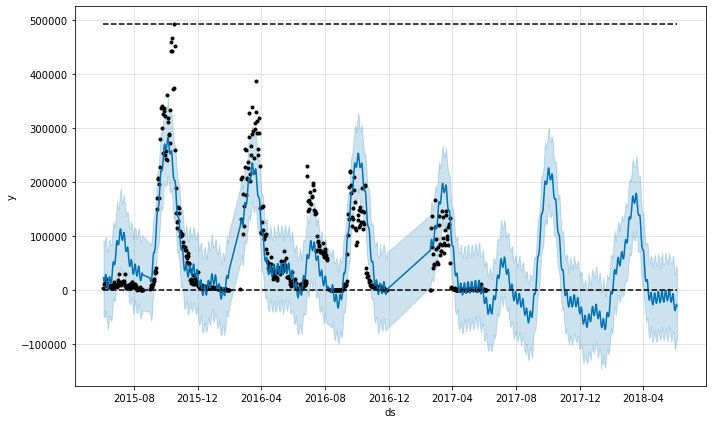

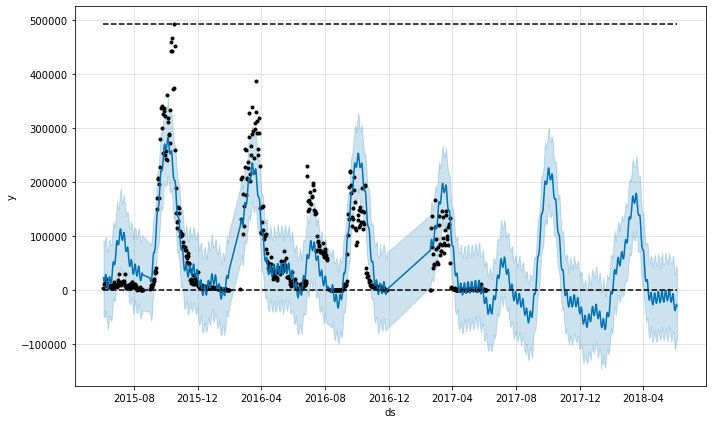

In [77]:
# Plot forecast
model.plot(forecast)

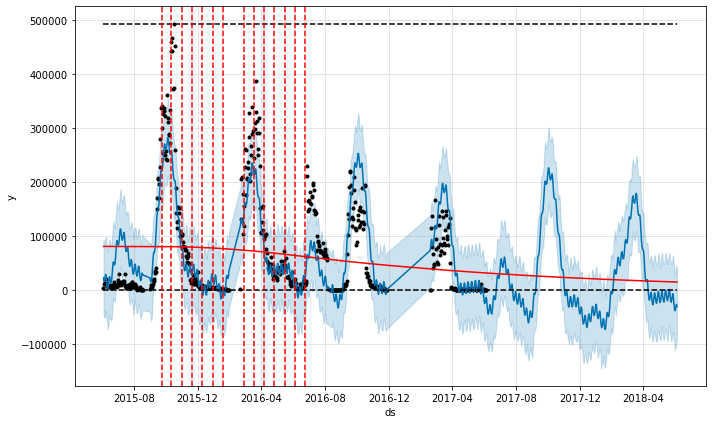

In [78]:
# Changing trend points
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

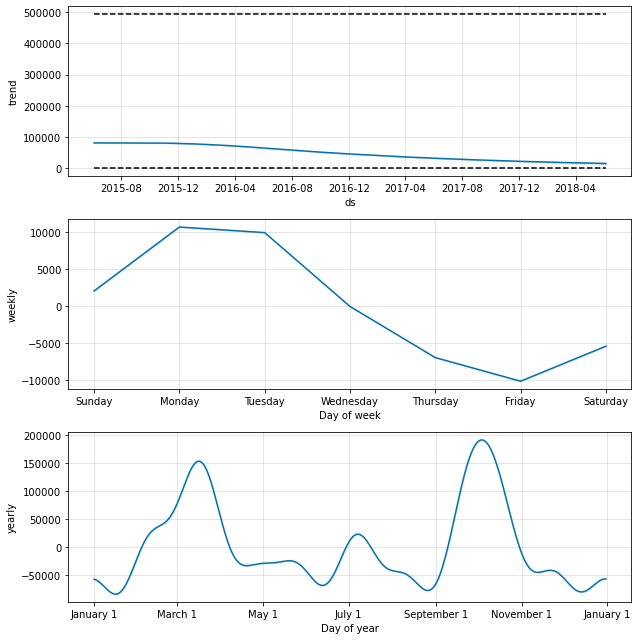

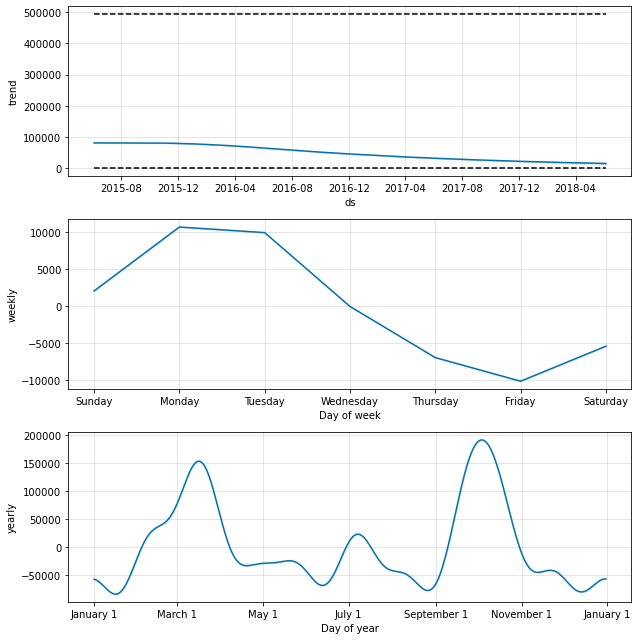

In [79]:
# Plot decomposition
model.plot_components(forecast)

#### Remove 2017 from data

In [80]:
new_final = final.iloc[:505]
# create Prophet model with American and Chinese holidays
new_model = Prophet(growth = 'logistic', yearly_seasonality=True)
#new_model.add_country_holidays(country_name='US')
#new_model.add_country_holidays(country_name='China')

# fit the model
new_model.fit(new_final)

# perform forecast
new_future = new_model.make_future_dataframe(periods=365)
# set cap
new_future['cap'] = new_final['y'].max()
new_future['floor'] = 0
new_forecast = new_model.predict(new_future)

# Display forecast
display(new_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2015-06-04,10513.206970,-57879.953324,77889.390541
1,2015-06-05,4035.293127,-67942.415278,68584.936242
2,2015-06-06,7696.627506,-58283.355397,75406.585741
3,2015-06-07,13014.792446,-54662.516794,80722.340646
4,2015-06-08,16863.453573,-54279.107345,82823.513472
...,...,...,...,...
865,2017-11-23,-7109.182465,-75183.535754,58587.099160
866,2017-11-24,-11080.768372,-82711.313449,59415.464775
867,2017-11-25,-5392.829512,-80445.771694,60965.385920
868,2017-11-26,1400.398569,-70982.226931,65367.774320


In [81]:
new_final

,ds,y,cap,floor
0,2015-06-04,5275.0,493881.0,0
1,2015-06-05,11399.0,493881.0,0
2,2015-06-06,13734.0,493881.0,0
3,2015-06-07,13044.0,493881.0,0
4,2015-06-08,12876.0,493881.0,0
...,...,...,...,...
500,2016-11-23,1773.0,493881.0,0
501,2016-11-24,620.0,493881.0,0
502,2016-11-25,984.0,493881.0,0
503,2016-11-26,630.0,493881.0,0


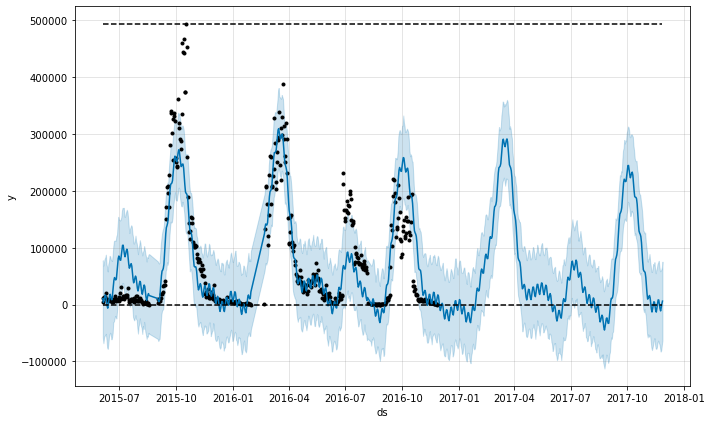

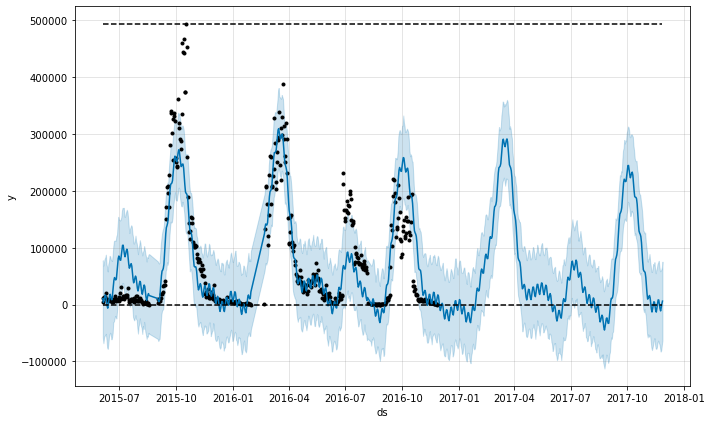

In [82]:
# Plot forecast
new_model.plot(new_forecast)

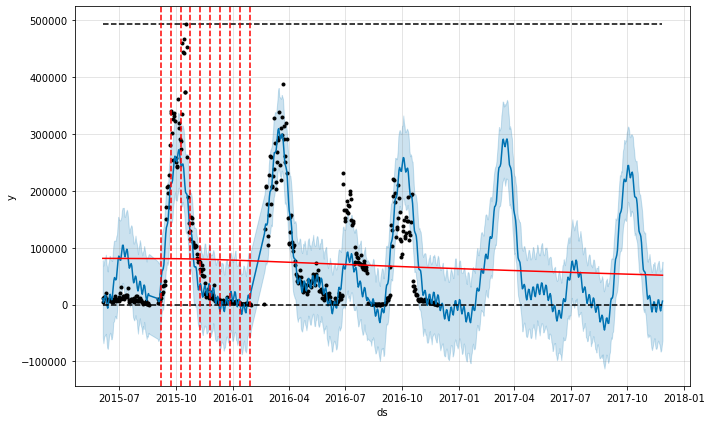

In [83]:
# Changing trend points
new_fig = new_model.plot(new_forecast)
new_a = add_changepoints_to_plot(new_fig.gca(), new_model, new_forecast)

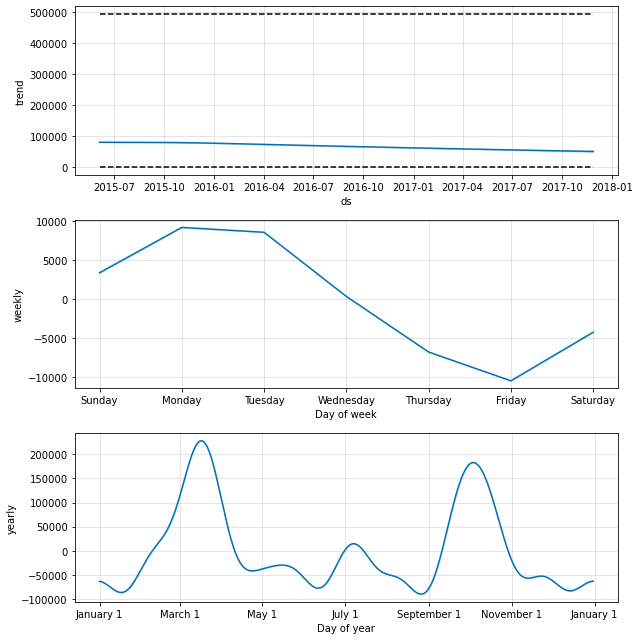

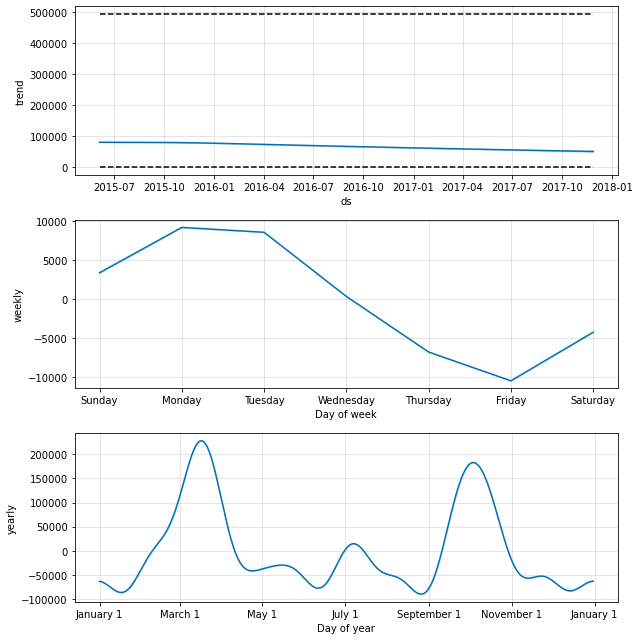

In [84]:
# Plot decomposition
new_model.plot_components(new_forecast)

### Train vs. Test

In [85]:
train = final.iloc[:333] # from June 4 2015 till June 4 2016
test = final.iloc[333:613] # from June 5 2016 till June 5 2017

In [86]:
# Provide cap and floor
train['cap'] = train['y'].max()
train['floor'] = 0
# create Prophet model with American and Chinese holidays
m = Prophet(growth = 'logistic', yearly_seasonality=True)
#model.add_country_holidays(country_name='US')
#model.add_country_holidays(country_name='China')

# fit the model
m.fit(train)

# perform forecast
fut = model.make_future_dataframe(periods=len(test))
# set cap
fut['cap'] = final['y'].max()
fut['floor'] = 0
f = model.predict(fut)

# Display forecast
display(f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

C:\Users\Chris\AppData\Local\Temp/ipykernel_10380/2369045117.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cap'] = train['y'].max()
C:\Users\Chris\AppData\Local\Temp/ipykernel_10380/2369045117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['floor'] = 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2015-06-04,23123.728671,-50332.450774,91723.032170
1,2015-06-05,16856.419948,-52143.095973,88809.762309
2,2015-06-06,18638.796909,-47546.929873,88634.580334
3,2015-06-07,23337.069599,-46712.696168,96243.279600
4,2015-06-08,29477.948748,-38676.206172,101602.936328
...,...,...,...,...
888,2018-03-08,132273.324332,62555.692986,199370.643018
889,2018-03-09,135247.127296,66245.561159,204624.298758
890,2018-03-10,145760.349100,75987.877111,216388.408818
891,2018-03-11,158490.684556,95773.507760,227864.920585


0.054720843268834904


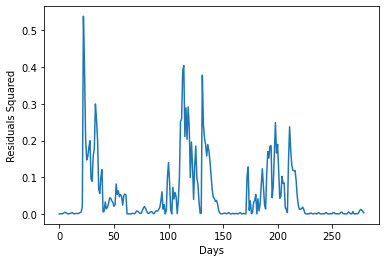

In [88]:
#print MAE 2
from sklearn.metrics import mean_squared_error

y_true = test['y'].values
endpoint = len(train)+len(test)
y_pred = f['yhat'][len(train):endpoint].values

#compute min-max scaled residuals
y_max = np.max(y_true)
y_min = np.min(y_true)

residuals_sq = np.square((y_true - y_pred)/(y_max - y_min))

#Plot residuals squared
plt.plot(residuals_sq)
plt.xlabel("Days")
plt.ylabel("Residuals Squared")

#Compute overall measure
mse = mean_squared_error(y_true, y_pred)
mse_minmax = mse /((y_max - y_min)**2)
print(mse_minmax)

In [89]:
# Print MAE

mae = mean_absolute_error(y_true, y_pred)
print('Trained from June 4 2015 till June 4 2016')
print('Tested from June 5 2016 till June 5 2017')
print('MAE =', round(mae, 3))

Trained from June 4 2015 till June 4 2016
Tested from June 5 2016 till June 5 2017
MAE = 38632.051


<AxesSubplot:xlabel='ds'>

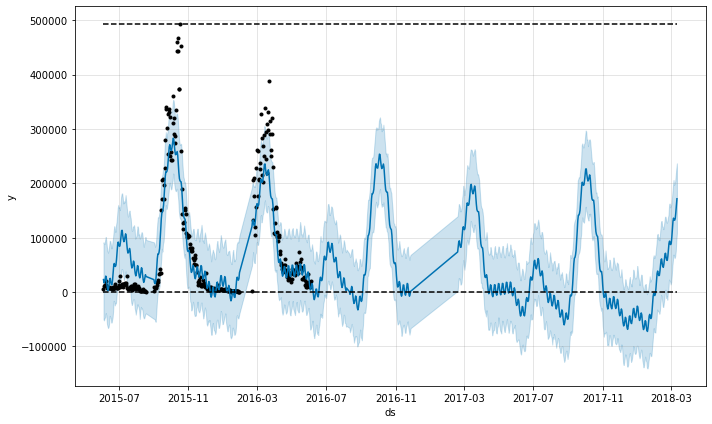

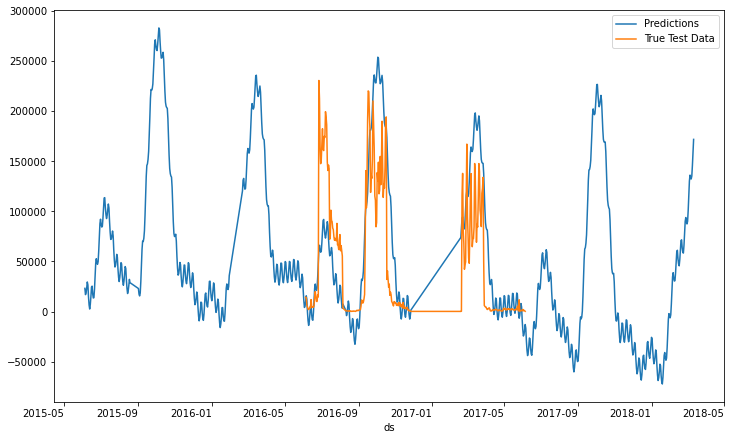

In [90]:
# Plot forecast
m.plot(f)
ax=f.plot(x='ds',y='yhat',legend=True,label='Predictions',figsize=(12,8))
test.plot(x='ds', y='y',legend=True, label='True Test Data', ax=ax)

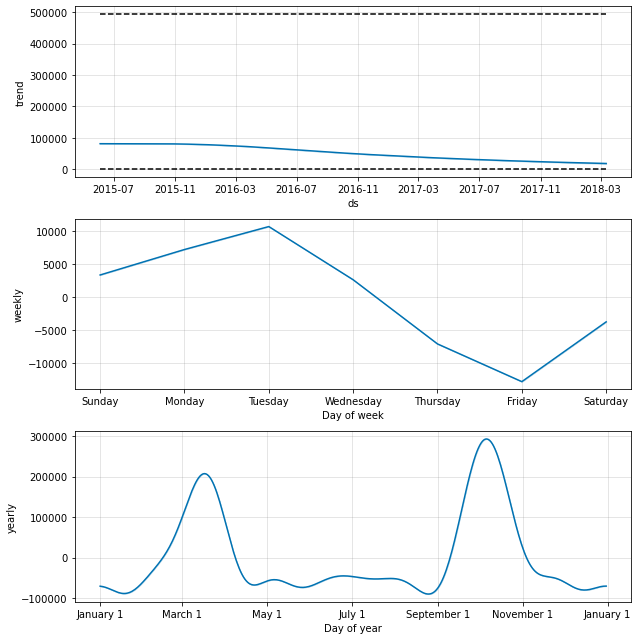

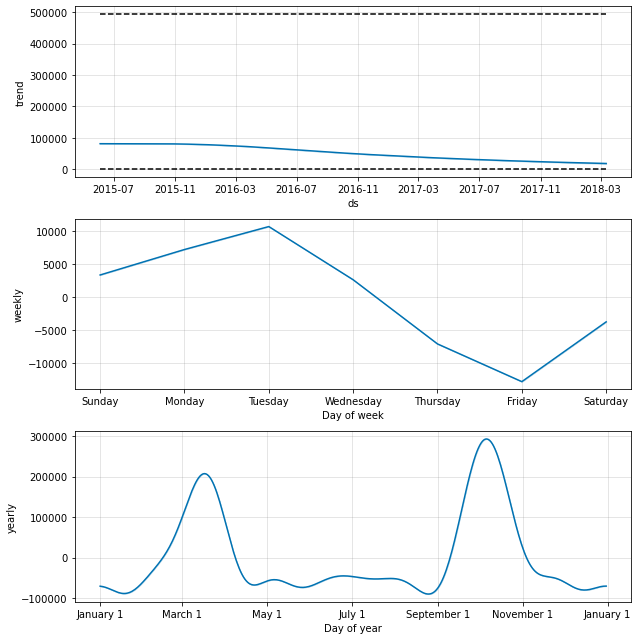

In [91]:
# Plot decomposition
m.plot_components(f)

#### Performance metrics

In [92]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [93]:
# Initial training period.
initial = len(train)
initial = str(initial) + ' days'

# Period length that we perform the cross validation for.
period = len(train)
period = str(period) + ' days'

# Horizon of prediction essentially for each fold.
horizon = len(test)
horizon = str(horizon) + ' days'

fb_cv = cross_validation(model, initial=initial, horizon=horizon)

# Performance Metrics of fb_cv
performance_metrics(fb_cv)

INFO:prophet:Making 1 forecasts with cutoffs between 2016-08-29 00:00:00 and 2016-08-29 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,19 days,4.068899e+09,63787.922660,54255.387231,9.536347,8.236015,1.265823,0.421053
1,20 days,4.082351e+09,63893.276576,54530.253659,8.603713,7.093108,1.177290,0.421053
2,21 days,4.332830e+09,65824.238521,57249.373006,7.174619,6.841472,1.095493,0.368421
3,22 days,4.900093e+09,70000.665239,61915.714598,6.503048,5.894550,1.027721,0.315789
4,23 days,6.473497e+09,80458.047614,70127.109068,5.980296,1.462026,0.982628,0.263158
...,...,...,...,...,...,...,...,...
175,276 days,9.056408e+09,95165.162587,94710.642968,76.693427,55.258807,1.904358,0.000000
176,277 days,8.802882e+09,93823.675874,93222.280436,79.970730,65.112117,1.908085,0.000000
177,278 days,8.508681e+09,92242.514387,91602.578329,80.410521,65.112117,1.908598,0.000000
178,279 days,8.229313e+09,90715.560763,90134.255165,83.268393,66.340330,1.910388,0.000000


C:\Users\Chris\anaconda3\lib\site-packages\prophet\plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\Chris\anaconda3\lib\site-packages\prophet\plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


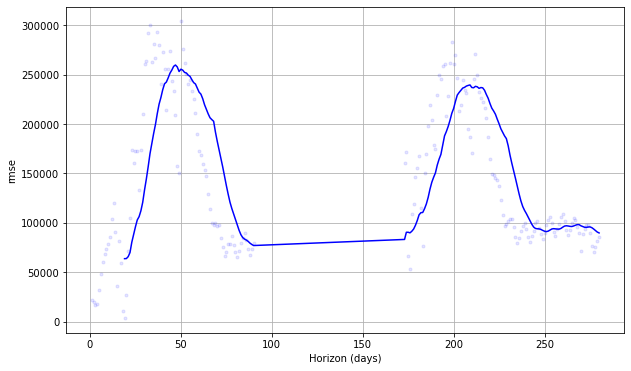

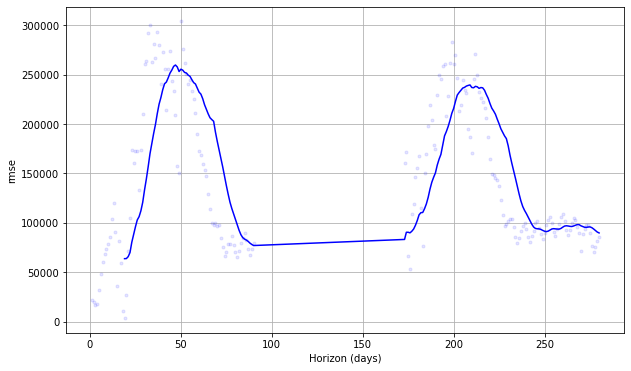

In [94]:
plot_cross_validation_metric(fb_cv,'rmse')

C:\Users\Chris\anaconda3\lib\site-packages\prophet\plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\Chris\anaconda3\lib\site-packages\prophet\plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


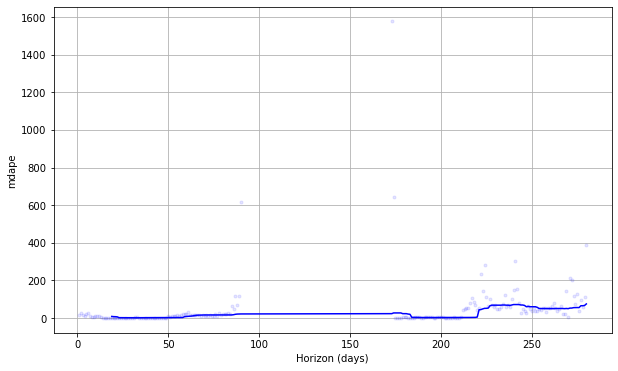

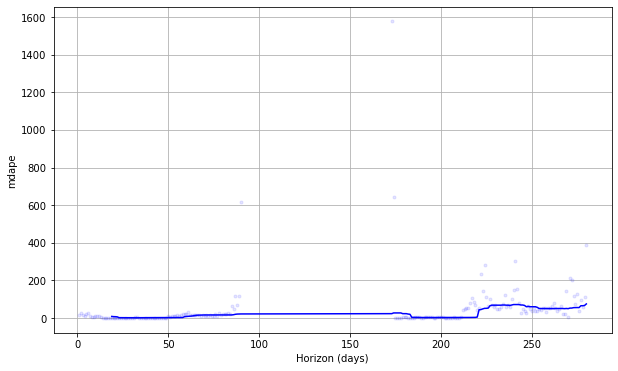

In [95]:
plot_cross_validation_metric(fb_cv,'mdape')